<a href="https://colab.research.google.com/github/julianaquin/Deep_Learning-UCA_Projects/blob/main/Seq2seq_Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import tensorflow.keras as tf
from tensorflow.keras import *
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset='/content/drive/My Drive/Colab Notebooks/DL2/fra.txt'

In [ ]:
data = pd.read_table(dataset)
data.head()

,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
0,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In the X data I add the french phrases

In [ ]:
#French
X= data.iloc[:,1]
X.head()

0       Marche.
1    En route !
2       Bouge !
3       Salut !
4        Salut.
Name: Va !, dtype: object

In the Y data I add the english phrases

In [ ]:
#English
y= data.iloc[:,0]
y.head()

0    Go.
1    Go.
2    Go.
3    Hi.
4    Hi.
Name: Go., dtype: object

I take an ammount of X and y instead of the whole data

In [ ]:
X= X[:6000]

In [ ]:
y= y[:6000]

In [ ]:
import unicodedata

In [ ]:
def step1(sent): # sent = on sentence in a   language
  def unicode_to_ascii(s): return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
  sent = unicode_to_ascii(sent.lower().strip()) # Only lower characters
  #sent = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sent)
  # Remove dots, spaces, and exclamation marks
  sent = re.sub(r"[.!\s]+", " ", sent)

  # creating a space between a word and the punctuation following it. E.g. "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python- padding-punctuation-with-white-spaces-keeping-punctuation
  sent = re.sub(r"([?.!,¿])", r" \1 ", sent)
  return '<start> ' + sent.strip() + ' <end>'

Now I apply the previous function to the dataset to regularize the texts

In [ ]:
X_= X.apply(step1)
y_= y.apply(step1)

In [ ]:
X_.head()

0      <start> marche <end>
1    <start> en route <end>
2       <start> bouge <end>
3       <start> salut <end>
4       <start> salut <end>
Name: Va !, dtype: object

In [ ]:
import io

In [ ]:
def voc(lang):
  # a list of sentences in the same language
  lengths = [len(txt.split()) for txt in lang]
  vocab = set([w for txt in lang for w in txt.split()])
  return max(lengths), list(vocab), len(vocab)+2 # for padding and OOV
  max_length1, vocab1, vocab_size1 = voc(sentences1)
  # Build vectorizer layer

In [ ]:
voc(['Marchez!'])

(1, ['Marchez!'], 3)

In [ ]:
step1(X[10])

'<start> cours <end>'

In [ ]:
X_.shape

(6000,)

Apply the voc function into the french and english sentences

In [ ]:
#French
max_length, vocab1, voc_size = voc(X_)

#english

max_length2, vocab2, voc_size2 = voc(y_)

I create two vectorizers

In [ ]:
vectorizer_french = tf.layers.TextVectorization(standardize=None, output_mode='int', vocabulary=vocab1, name= "french")
vectorizer_english = tf.layers.TextVectorization(standardize=None, output_mode='int', vocabulary=vocab2, name= "english") #Check

In [ ]:
voc_size

2930

In [ ]:
voc_size2

1374

Then I vectorize the french and english vocabulary (which were my X_ and y_)

In [ ]:

X_= np.array(vectorizer_french(X_))
y_= np.array(vectorizer_english(y_))

In [ ]:
y_after= y_[:,1:]

In [ ]:
X_.shape,  y_.shape

((6000, 12), (6000, 7))

In [ ]:
y_after.shape

(6000, 6)

In [ ]:
y_after= np.hstack((y_after, np.zeros((y_after.shape[0], 1))))
y_after.shape

(6000, 7)

In [ ]:
latent_dim= 32
emb_dim=50

I create the encoder_decoder model and train it

In [ ]:
#Define the enconder
enc_inputs = tf.layers.Input(shape=(None,), name="french_input")
enc = tf.layers.Embedding(voc_size, emb_dim, name="fr_embedding")(enc_inputs)
_, enc_state_h, enc_state_c = tf.layers.LSTM(latent_dim, return_sequences=False, return_state=True)(enc)
context = [enc_state_h, enc_state_c]

#Define the decoder
dec_inputs = tf.layers.Input(shape=(None,))
dec = tf.layers.Embedding(voc_size, emb_dim, name="en_embedding")(dec_inputs)
dec, _, _ = tf.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name="lstm_dec")(dec, initial_state=context)
dec_outputs = tf.layers.Dense(voc_size, activation="softmax", name="dec_dense")(dec)

In [ ]:
# Define the EncoderDecoder model
model = Model ([enc_inputs, dec_inputs], dec_outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 french_input (InputLayer)   [(None, None)]               0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 fr_embedding (Embedding)    (None, None, 50)             146500    ['french_input[0][0]']        
                                                                                                  
 en_embedding (Embedding)    (None, None, 50)             146500    ['input_1[0][0]']             
                                                                                              

In [ ]:
#compile and fit the EncoderDecoder model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit([X_, y_],y_after ,batch_size=32,epochs=16)

Epoch 1/16
188/188 [==============================] - 12s 37ms/step - loss: 4.5272
Epoch 2/16
188/188 [==============================] - 5s 27ms/step - loss: 2.5146
Epoch 3/16
188/188 [==============================] - 5s 28ms/step - loss: 2.2730
Epoch 4/16
188/188 [==============================] - 8s 44ms/step - loss: 2.1601
Epoch 5/16
188/188 [==============================] - 5s 27ms/step - loss: 2.0723
Epoch 6/16
188/188 [==============================] - 6s 34ms/step - loss: 1.9670
Epoch 7/16
188/188 [==============================] - 5s 27ms/step - loss: 1.8682
Epoch 8/16
188/188 [==============================] - 5s 27ms/step - loss: 1.7852
Epoch 9/16
188/188 [==============================] - 7s 35ms/step - loss: 1.7170
Epoch 10/16
188/188 [==============================] - 6s 33ms/step - loss: 1.6501
Epoch 11/16
188/188 [==============================] - 10s 56ms/step - loss: 1.5892
Epoch 12/16
188/188 [==============================] - 10s 55ms/step - loss: 1.5348
Epoch 13/1

## Inference Model

Building of only encoder model

In [ ]:

enc_inputs= model.inputs[0]
lstm_enc= model.get_layer("lstm")
_, enc_state_h, enc_state_c = lstm_enc.output

encoder_model = Model(enc_inputs, [enc_state_h, enc_state_c])

Building of the decoder model

In [ ]:
#we get the trained layers of the decoder part of our model
dec_inputs = tf.layers.Input(shape=(None,), name="english_input")
dec_state_input_h = tf.layers.Input(shape=(latent_dim,), name="dec_state_input_h")
dec_state_input_c = tf.layers.Input(shape=(latent_dim,), name="dec_state_input_c")

#we call the dec_emedding and lstm_decoder from our trained model using the get layer method
dec_emb = model.get_layer("en_embedding")
lstm= model.get_layer("lstm_dec")
#get embedding
emb_output= dec_emb(dec_inputs)

#we pass on the emb_output into the lstm layer we just got previously from the trained model
out_lstm, dec_state_h, dec_state_c = lstm(emb_output, initial_state=[dec_state_input_h, dec_state_input_c])

dec_densee = model.get_layer("dec_dense")

dec_outputs = dec_densee(out_lstm)

#Define the Decoder mode
decoder_model = Model(
    inputs=[dec_inputs, dec_state_input_h, dec_state_input_c],
    outputs=[dec_outputs, dec_state_h, dec_state_c]
)

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 french_input (InputLayer)   [(None, None)]            0         
                                                                 
 fr_embedding (Embedding)    (None, None, 50)          146500    
                                                                 
 lstm (LSTM)                 [(None, 32),              10624     
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
Total params: 157124 (613.77 KB)
Trainable params: 157124 (613.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 english_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 en_embedding (Embedding)    (None, None, 50)             146500    ['english_input[0][0]']       
                                                                                                  
 dec_state_input_h (InputLa  [(None, 32)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 dec_state_input_c (InputLa  [(None, 32)]                 0         []                      

In [ ]:
s_vocabulary = vectorizer_french.get_vocabulary()
target_vocabulary = vectorizer_english.get_vocabulary()

In [ ]:
word2index_target = {w:i for i, w in enumerate(target_vocabulary)}

In [ ]:
word2index_target["<start>"], word2index_target["<end>"]

(1357, 1118)

Function to decode the a sequence using the encoder_model and decoder_model

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((len(input_seq), 1))
    target_seq[:, 0] = word2index_target["<start>"]
    end_tok_index = word2index_target["<end>"]

    out_seqs = []

    for _ in range(len(input_seq)):
      out_seqs.append(list())

    for _ in range(max_length2):
      toks, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

      next_toks = np.argmax(toks[:, -1, :], axis=1)
      for i, next_tok in enumerate(next_toks):

        #if next_token isn't the end nor zero then we append it to our output sequence
        if next_tok != end_tok_index and next_tok != 0:
          out_seqs[i].append(next_tok)

        target_seq[:, 0] = next_toks
      states_value = [h, c]
      #If in the sequence the next_toks are all in the end then we break out of the loop and return the output sequences list
      if np.all(next_toks == end_tok_index):
        break
    return out_seqs


In [ ]:
X_[10, None].shape

(1, 12)

In [ ]:
decode_sequence(X_[10, np.newaxis])

[[173]]

In [ ]:
preds = decode_sequence(X_[300:308])

preds

[[173, 596], [173, 1334, 419], [692, 774], [173, 596], [309], [309], [], [309]]

In [ ]:
def prediction_to_sentence(indices):
  return " ".join([target_vocabulary[idx] for idx in indices]).strip()

Comparison between the translations

In [ ]:
print(X[106]), prediction_to_sentence(y_[106]), prediction_to_sentence(preds[6])

Montez.


(None, '<start> hop in <end>', '')

## Seq2Seq with Attention

SAme as before but we apply an attention layer

In [ ]:
#Define the enconder
enc_inputs = tf.layers.Input(shape=(None,), name="french_input")
enc = tf.layers.Embedding(voc_size, emb_dim, name="fr_embedding")(enc_inputs)
enc_output, enc_state_h, enc_state_c = tf.layers.LSTM(latent_dim, return_sequences=True, return_state=True)(enc)
context = [enc_state_h, enc_state_c]

#Define the decoder
dec_inputs = tf.layers.Input(shape=(None,))
dec = tf.layers.Embedding(voc_size, emb_dim, name="en_embedding")(dec_inputs)
dec, _, _ = tf.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name="lstm_dec")(dec, initial_state=context)
# Attention
attention = tf.layers.Attention()([dec, enc_output])
dec_outputs = tf.layers.Dense(voc_size, activation="softmax", name="dec_dense")(dec)

attention_model = Model([enc_inputs, dec_inputs], dec_outputs)


In [ ]:
attention_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 french_input (InputLayer)   [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 fr_embedding (Embedding)    (None, None, 50)             146500    ['french_input[0][0]']        
                                                                                                  
 en_embedding (Embedding)    (None, None, 50)             146500    ['input_2[0][0]']             
                                                                                            

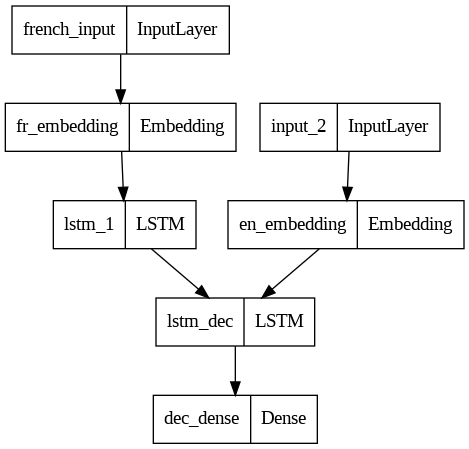

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(attention_model)

In [ ]:
#compiling and fitting the EncoderDecoder Attention model
attention_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
attention_model.fit([X_, y_],y_after ,batch_size=32,epochs=16)

Epoch 1/16
188/188 [==============================] - 10s 28ms/step - loss: 4.5348
Epoch 2/16
188/188 [==============================] - 7s 36ms/step - loss: 2.6672
Epoch 3/16
188/188 [==============================] - 5s 28ms/step - loss: 2.3891
Epoch 4/16
188/188 [==============================] - 8s 41ms/step - loss: 2.1885
Epoch 5/16
188/188 [==============================] - 12s 63ms/step - loss: 2.0800
Epoch 6/16
188/188 [==============================] - 12s 65ms/step - loss: 2.0103
Epoch 7/16
188/188 [==============================] - 7s 38ms/step - loss: 1.9496
Epoch 8/16
188/188 [==============================] - 5s 27ms/step - loss: 1.8778
Epoch 9/16
188/188 [==============================] - 6s 30ms/step - loss: 1.8065
Epoch 10/16
188/188 [==============================] - 6s 33ms/step - loss: 1.7434
Epoch 11/16
188/188 [==============================] - 5s 27ms/step - loss: 1.6807
Epoch 12/16
188/188 [==============================] - 7s 35ms/step - loss: 1.6253
Epoch 13/1

Inference model part

In [ ]:
#Building of encoder attention model
at_enc_inputs= attention_model.inputs[0]
lstm_enc_at= attention_model.get_layer("lstm_1")
_, enc_state_h, enc_state_c = lstm_enc_at.output

att_encoder_model = Model(at_enc_inputs, [enc_state_h, enc_state_c])

In [ ]:
att_encoder_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 french_input (InputLayer)   [(None, None)]            0         
                                                                 
 fr_embedding (Embedding)    (None, None, 50)          146500    
                                                                 
 lstm_1 (LSTM)               [(None, None, 32),        10624     
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
Total params: 157124 (613.77 KB)
Trainable params: 157124 (613.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Building of the decoder model (we get the trained layers of the decoder part of our model)
dec_inputs = tf.layers.Input(shape=(None,), name="english_input")
dec_state_input_h = tf.layers.Input(shape=(latent_dim,), name="dec_state_input_h")
dec_state_input_c = tf.layers.Input(shape=(latent_dim,), name="dec_state_input_c")

#we call the dec_emedding and lstm_decoder from our trained model using the get layer method
dec_emb = model.get_layer("en_embedding")
lstm= model.get_layer("lstm_dec")
#get embedding
emb_output= dec_emb(dec_inputs)

#we pass on the emb_output into the lstm layer we just got previously from the trained model
out_lstm, dec_state_h, dec_state_c = lstm(emb_output, initial_state=[dec_state_input_h, dec_state_input_c])

dec_densee = model.get_layer("dec_dense")

dec_outputs = dec_densee(out_lstm)

#Define the Decoder mode
att_decoder_model = Model(
    inputs=[dec_inputs, dec_state_input_h, dec_state_input_c],
    outputs=[dec_outputs, dec_state_h, dec_state_c]
)

In [ ]:
att_decoder_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 english_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 en_embedding (Embedding)    (None, None, 50)             146500    ['english_input[0][0]']       
                                                                                                  
 dec_state_input_h (InputLa  [(None, 32)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 dec_state_input_c (InputLa  [(None, 32)]                 0         []                      

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    states_value = att_encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((len(input_seq), 1))
    target_seq[:, 0] = word2index_target["<start>"]
    end_tok_index = word2index_target["<end>"]

    out_seqs = []

    for _ in range(len(input_seq)):
      out_seqs.append(list())

    for _ in range(max_length2):
      toks, h, c = att_decoder_model.predict([target_seq] + states_value, verbose=0)

      next_toks = np.argmax(toks[:, -1, :], axis=1)
      for i, next_tok in enumerate(next_toks):

        #if next_token isn't the end nor zero then we append it to our output sequence
        if next_tok != end_tok_index and next_tok != 0:
          out_seqs[i].append(next_tok)

        target_seq[:, 0] = next_toks
      states_value = [h, c]
      #If in the sequence the next_toks are all in the end then we break out of the loop and return the output sequences list
      if np.all(next_toks == end_tok_index):
        break
    return out_seqs

In [ ]:
att_preds = decode_sequence(X_[300:308])

In [ ]:
print(X[100]), prediction_to_sentence(y_[100]), prediction_to_sentence(att_preds[0])

Compris !


(None, '<start> got it <end>', 'go ?')